# Introduction

**The purpose of this anlaysis is trying to find out the products that are purchased most in the HappyDB dataset.**  
These products are more likely to make people feel happy.

**I'll use KOKO, a rule-based entity extraction system, to perform the analysis.**  

KOKO allows users to specify conditions of desirable entities with a declarative language (see [KOKO syntax](#koko_syntax)).  
Those entities that obtain scores higher than a threshold are extracted.

KOKO is especially suitable for entity extraction with limited evidence in the corpus (e.g. extraction of cafe names within only one or a few blogs). 

**The whole analysis described in this notebook comprises the following steps:**  

- Data preprocessing: load HappyDB dataset and convert it to a text file as input to KOKO.
- KOKO introduction: briefly introduce the syntax and semantics of KOKO, with an example query.
- Entity extraction: a KOKO query is written and evaluated, extracting product names in the dataset.

Let's get started!

We first import necessary packages:

In [6]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, ImageColorGenerator

# 1. Data preprocessing

First, let's load the data and take a look at the happy moments.  

## 1.1 Load HappyDB

In [7]:
hm_data = pd.read_csv('./cleaned_hm.csv')
hm_data.head()

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,category,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,affection,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,affection,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,exercise,1,NaN,exercise
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,bonding,2,bonding,bonding
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,affection,1,NaN,affection


The dataset has ten columns, within which the column 'cleaned_hm' is the cleaned description of people's happy moments. Our analysis will be mostly on the contents in this column.

## 1.2 Word count

Here's some statistical results based on the word counts.

In [8]:
df_hm = hm_data[hm_data['cleaned_hm'].notnull()]
len_count = df_hm['cleaned_hm'].apply(lambda x: len(x.split()))
len_count.describe()

count    100535.000000
mean         18.298503
std          21.474146
min           2.000000
25%           9.000000
50%          14.000000
75%          21.000000
max        1179.000000
Name: cleaned_hm, dtype: float64

Let's show more detailed results.

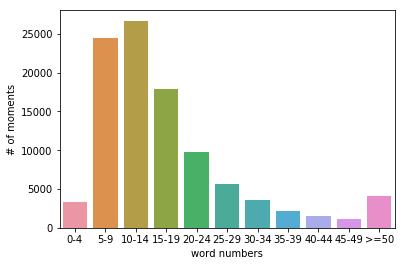

In [9]:
length_order = ["0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39", \
                "40-44", "45-49", ">=50"]
length_category = len_count.apply(lambda x: length_order[min(10, int(x/5))])
length_counts = pd.DataFrame(length_category.value_counts()).reset_index()
length_counts.columns = ['word numbers', '# of moments']

sns.barplot(x='word numbers', y='# of moments', data=length_counts, order=length_order)

## 1.3 Word frequency

(-0.5, 3599.5, 2699.5, -0.5)

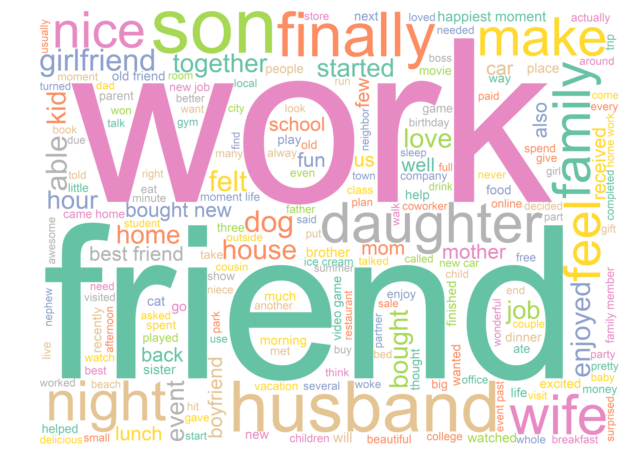

In [10]:
LIMIT_WORDS = ['happy', 'day', 'got', 'went', 'today', 'made', 'one', 'two', 'time', 'last', 'first', 'going', \
               'getting', 'took', 'yesterday', 'found', 'lot', 'really', 'saw', 'see', 'month', 'week', 'day', \
               'yesterday', 'year', 'ago', 'now', 'still', 'since', 'something', 'great', 'good', 'long', 'thing', \
               'toi', 'without', 'yesteri', '2s', 'toand', 'ing' ]

text = ' '.join(df_hm['cleaned_hm'].tolist())
text = text.lower()
for w in LIMIT_WORDS:
    text = text.replace(' ' + w, '')
    text = text.replace(w + ' ', '')
wordcloud = WordCloud(background_color="white", font_path='../../../Library/Fonts/Arial.ttf', \
                          height=2700, width=3600).generate(text)
plt.figure( figsize=(14,8) )
plt.imshow(wordcloud.recolor(colormap=plt.get_cmap('Set2')), interpolation='bilinear')
plt.axis("off")

# 2. Entity Extraction on HappyDB

We perform a few entity extraction tasks on HappyDB to get a deeper understanding of the dataset.

First we use a dictionary-based solution to identify seasons that make people happy.  
Next we use KOKO, an entity extraction system, to extract more subtle entities from the dataset.

## 2.1 Seasons that make people happy

In [11]:
seasons = ['Spring', 'Summer', 'Fall', 'Winter']

# Check each moment, and increase the count for the mentioned season
season_dic = dict((x,0) for x in seasons)
tokens_hm = df_hm['cleaned_hm'].apply(lambda x: x.split())
for _, value in tokens_hm.iteritems():
    for word in value:
        if word in seasons:
            season_dic[word] += 1
            
season_dic

{'Fall': 6, 'Spring': 81, 'Summer': 27, 'Winter': 6}

Spring is the most popular season -- as expected -- followed by Summer.  

Fall and Winter have equal number of mentioning.

## 2.2 Entity Extraction using Koko

Here I use an entity extraction system called Koko to perform the extraction task.  

KOKO is equipped with a declarative query language that makes it super easy to write queries for entity extraction.  
Anyone who's interested could find detailed introduction [here](./koko_intro.txt).

### 2.2.1 Generate plain-text happy moments

Koko queries take texts as input. Let's generate plain-text happy moments for query evaluation.

In [12]:
# Read the happyDB sample file
with open('./happydb.txt', 'w') as ofile:
    for i in range(0, df_hm.shape[0] - 1):
        ofile.write(df_hm['cleaned_hm'].iloc[i] + '\n')
        
print("Plain-text happy moments are generated!")

Plain-text happy moments are generated!


### 2.2.2 Extraction of purchased products

First, let's see what products are mentioned most in the happy moments.

To do this, we need to find the happy moments that are related to purchasing behavior.

The Koko query for product extraction is as follows:

In [13]:
with open('products.koko', 'r') as file:
    print(file.read())

extract "NPs" x from "./happydb.txt" if
	("purchase" ~ x {0.1})
with threshold 0.2



In [14]:
import koko
import spacy

koko.run('./products.koko', doc_parser='spacy')

Loading embedding models
Parsed query: extract "./happydb.txt" NPs from "x" if
	("['purchase']" (1.00) or 
"['buy']" (0.83) or 
"['purchasing']" (0.81) or 
"['buying']" (0.75) or 
"['purchases']" (0.74) or 
"['purchased']" (0.73) or 
"['sell']" (0.71) or 
"['discount']" (0.69) or 
"['discounted']" (0.66) or 
"['order']" (0.66) ~ x { 0.10 })   
with threshold 0.20


Results:

Entity name                                        Entity score
me                                                 1.000000
he                                                 1.000000
we                                                 1.000000
him                                                1.000000
it                                                 1.000000
something                                          1.000000
myself                                             1.000000
I                                                  1.000000
my son                                             1.000000
a new laptop      

There are a few problems with the query results:  
- First, the results contain a lot of noise, with pronouns such as "me", "he" and "my son".
- Second, a large amount of entities have their entity score as "1.000000", making it impossible to differentiate them.

For the first problem, Koko allows users to specify exclusion rules to get rid of the unwanted noise.  
The second problem can be solved by lowering the weight of the rule.

Here's an updated query:

In [19]:
with open('products_v2.koko', 'r') as file:
    print(file.read())

extract "NPs" x from "./happydb.txt" if
	("purchase" ~ x {0.01})
with threshold 0.1
excluding(str(x) matches ".*(I|me|my|we|our|us|he|his|him|she|her|they|them|it|its).*")



In [20]:
import koko
import spacy

koko.run('./products_v2.koko', doc_parser='spacy')

Parsed query: extract "./happydb.txt" NPs from "x" if
	("['purchase']" (1.00) or 
"['buy']" (0.83) or 
"['purchasing']" (0.81) or 
"['buying']" (0.75) or 
"['purchases']" (0.74) or 
"['purchased']" (0.73) or 
"['sell']" (0.71) or 
"['discount']" (0.69) or 
"['discounted']" (0.66) or 
"['order']" (0.66) ~ x { 0.01 })   
with threshold 0.10
excluding
	(str(x) matches ".*(I|me|my|we|our|us|he|his|him|she|her|they|them|it|its).*")


Results:

Entity name                                        Entity score
a new car                                          0.652546
tickets                                            0.286813
work                                               0.282934
sale                                               0.251906
i                                                  0.234248
many things                                        0.218813
a new smartphone                                   0.215396
money                                              0.201879
a car        

Maybe the results are better if we use binary conditions?

In [22]:
import koko
import spacy

koko.run('./products_v3.koko', doc_parser='spacy')

Parsed query: extract "./happydb.txt" NPs from "x" if
	("purchased" x { 0.05 }) or
	("bought" x { 0.05 })   
with threshold 0.20
excluding
	(str(x) matches ".*(I|me|my|we|our|us|he|his|him|she|her|they|them|it|its).*")


Results:

Entity name                                        Entity score
a new phone                                        1.000000
a new laptop                                       1.000000
a new pair                                         1.000000
a new car                                          1.000000
tickets                                            1.000000
a New Computer                                     1.000000
a new smartphone                                   1.000000
a new bike                                         1.000000
a car                                              1.000000
many things                                        1.000000
a new watch                                        0.950000
a new TV                                     

### 2.2.3 Extraction of locations

In [10]:
with open('locations.koko', 'r') as file:
    print(file.read())

extract "Ents" x from "./happydb.txt" if
     	  ("travel" ~ x {0.1})
with threshold 0.2
 



In [11]:
koko.run('./locations.koko', doc_parser='spacy')

INFO 2017-10-10 14:33:55,722 - Loading SpaCy English models
INFO 2017-10-10 14:33:55,722 - Loading SpaCy English models
INFO 2017-10-10 14:33:58,656 - Done
INFO 2017-10-10 14:33:58,656 - Done
!!Expansion results:
[(['travel'], 1.0), (['traveling'], 0.7263600885615277), (['travelling'], 0.7101778587731454), (['travelers'], 0.6698850470334886), (['vacations'], 0.6628397906573841), (['destinations'], 0.6587129176641364), (['trips'], 0.63681915517429), (['trip'], 0.6323668177588403), (['travels'], 0.618695099915189), (['vacation'], 0.6179892073547634)]
Parsed query: extract "./happydb.txt" Ents from "x" if
	("['travel']" (1.00) or 
"['traveling']" (0.73) or 
"['travelling']" (0.71) or 
"['travelers']" (0.67) or 
"['vacations']" (0.66) or 
"['destinations']" (0.66) or 
"['trips']" (0.64) or 
"['trip']" (0.63) or 
"['travels']" (0.62) or 
"['vacation']" (0.62) ~ x { 0.10 })   
with threshold 0.20


Results:

Entity name                                        Entity score
yesterday           

## A logistic regression classifier for gender

Now we are trying to train a logistic regression model for classifying the gender of happy moments.

To do this, we first need the demographic data of happy moments.

In [12]:
demo_data = pd.read_csv('./demographic.csv')

demo_data.head()

,wid,age,country,gender,marital,parenthood
0,1,37.0,USA,m,married,y
1,2,29.0,IND,m,married,y
2,3,25,IND,m,single,n
3,4,32,USA,m,married,y
4,5,29,USA,m,married,y


We then join the happy moments and the demographic data -- based on the "wid" column -- 
to identify the author's gender for each happy moment.

In [13]:
merge_data = pd.merge(hm_data, demo_data, on='wid')
gender_data = merge_data[['cleaned_hm', 'gender']]

gender_data.head()

,cleaned_hm,gender
0,I went on a successful date with someone I fel...,m
1,I played a new game that was fun and got to en...,m
2,I listened to some music and heard an entire a...,m
3,Went to see a movie with my friend,m
4,"Played guitar, learning a song on it",m


We can take a look at the frequency distribution for gender.

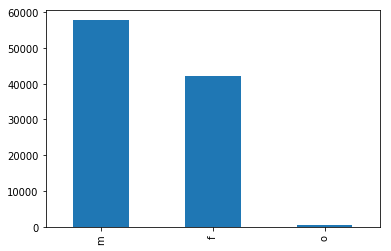

In [14]:
gender_data.gender.value_counts().plot(kind='bar')

For simplicity, we make this a binary classification problem, by only classifying happy moments between male(1) or female(0).  
Let's clean the data set to remove happy moments whose gender is neither male nor female.

In [15]:
gender_bin_data = gender_data[(gender_data['gender'] == 'm') | (gender_data['gender'] == 'f')]

gender_bin_data['cleaned_hm'].size

99759

In [16]:
gender_bin_data['gender_bin'] = np.where(gender_bin_data['gender']=='m', 1, 0)

gender_bin_data.head()

/Users/chen/.virtualenv/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,cleaned_hm,gender,gender_bin
0,I went on a successful date with someone I fel...,m,1
1,I played a new game that was fun and got to en...,m,1
2,I listened to some music and heard an entire a...,m,1
3,Went to see a movie with my friend,m,1
4,"Played guitar, learning a song on it",m,1


The next step is to preprocess the happy moments so that they can be used as useful features.

We use the first 70% happy moments as the training data, with the rest 30% as test data.

In [17]:
hm_size = gender_bin_data['cleaned_hm'].size
num_train_hm = int(0.7 * gender_bin_data['cleaned_hm'].size)

train_hm = gender_bin_data.iloc[0:num_train_hm]
test_hm = gender_bin_data.iloc[num_train_hm:hm_size]
test_hm = test_hm.reset_index(drop=True)

test_hm.head()

,cleaned_hm,gender,gender_bin
0,"I started to walk more around the office, meet...",f,0
1,I bought my mom a bonsai tree for Mother's Day...,f,0
2,I was able to plan out the next two months as ...,f,0
3,I had dinner with coworkers who were leaving e...,f,0
4,I bought presents for my nieces for their home...,f,0


We further clean up the texts, to remove numbers and punctuation.

In [18]:
def clean_up_texts(hm_data):
    prepro_hm = []
    stops = set(stopwords.words("english"))
    for i in range(0, hm_data['cleaned_hm'].size):
        # Remove non-english words, including punctuations and numbers
        letters = re.sub("[^a-zA-Z]", " ", hm_data.iloc[i]['cleaned_hm'])

        # Convert all words to lower case
        lower_words = letters.lower()

        # Tokenize the sentences
        tokens = lower_words.split()

        # Reconstruct the processed tokens into a string
        prepro_string = " ".join(tokens)

        prepro_hm.append(prepro_string)
        
    return prepro_hm
    
prepro_train = clean_up_texts(train_hm)
prepro_test = clean_up_texts(test_hm)
print("Preprocessing done! \n")

Preprocessing done! 



An example of the preprocessed training data:

In [19]:
prepro_train[0]

'i went on a successful date with someone i felt sympathy and connection with'

We use scikit-learn to build the features of our bag-of-words model

In [20]:
vectorizer = CountVectorizer()
features_train_hm = vectorizer.fit_transform(prepro_train)
train_array_hm = features_train_hm.toarray()

train_array_hm.shape

(69831, 20737)

A quick look at the features we use:

In [21]:
vocab = vectorizer.get_feature_names()

vocab

['aa',
 'aaa',
 'aadat',
 'aadhaar',
 'aadhar',
 'aagra',
 'aakshayatriya',
 'aas',
 'aashwin',
 'ab',
 'aback',
 'abacus',
 'abandon',
 'abandoned',
 'abasket',
 'abating',
 'abbott',
 'abby',
 'abc',
 'abcs',
 'abd',
 'abdillah',
 'abdomen',
 'abdullah',
 'abeading',
 'abhai',
 'abidaia',
 'abig',
 'abilities',
 'ability',
 'able',
 'abnormalities',
 'aboard',
 'abode',
 'abodes',
 'abook',
 'aborad',
 'abot',
 'abound',
 'about',
 'above',
 'abra',
 'abroad',
 'abrupt',
 'abruptly',
 'abs',
 'abscess',
 'abscesses',
 'absence',
 'absent',
 'absentee',
 'abso',
 'absolute',
 'absolutely',
 'absorb',
 'absorbed',
 'abstained',
 'abstaining',
 'abstract',
 'absurd',
 'absurdity',
 'absurdly',
 'abt',
 'abundance',
 'abundant',
 'abuse',
 'abused',
 'abusive',
 'abut',
 'ac',
 'aca',
 'academic',
 'academically',
 'academics',
 'academy',
 'acai',
 'acancer',
 'accent',
 'accenture',
 'accept',
 'acceptable',
 'acceptance',
 'accepted',
 'accepting',
 'accepts',
 'access',
 'accessable'

Now we can train a simple logistic regression model with the extracted features.  

Let's train the logistic regression model:

In [22]:
from sklearn.linear_model import LogisticRegression

logi_model = LogisticRegression()
logi_model.fit(train_array_hm, train_hm['gender_bin'])

logi_model.score(train_array_hm, train_hm['gender_bin'])

0.76023542552734458

We can see which words are most influential by looking at the coefficients of the logistic model.

In [23]:
feature_names = vocab
coefficients = logi_model.coef_.tolist()[0]
weight_df = pd.DataFrame({'Word': feature_names,
                          'Coeff': coefficients})
weight_df = weight_df.sort_values(['Coeff', 'Word'], ascending=[0, 1])
weight_df.head(n=10)

,Coeff,Word
20291,3.178912,wife
7642,2.850127,girlfriend
7593,2.001084,gf
17551,1.917807,stone
16855,1.832706,smoking
14631,1.776490,reaches
16091,1.755520,seattle
1661,1.747573,begging
3441,1.674358,climbs
20172,1.660420,wend


And also the least influential words:

In [24]:
weight_df.tail(n=10)

,Coeff,Word
7857,-1.957479,grandkids
11991,-1.979667,nails
8774,-2.092423,hubby
1292,-2.099750,babysit
1953,-2.118816,blissful
10043,-2.153748,knitting
10932,-2.278422,makeup
11846,-2.541355,mth
2195,-2.633498,boyfriend
8842,-3.364651,husband


To evaluate the performance, let's use the trained model to make prediction on the test data.

In [25]:
features_test_hm = vectorizer.transform(prepro_test)
test_array_hm = features_test_hm.toarray()

test_array_hm.shape

(29928, 20737)

In [26]:
predictions = logi_model.predict(test_array_hm)

In [27]:
from sklearn import metrics

print(metrics.accuracy_score(test_hm['gender_bin'], predictions))

0.639468056669


We use the first 70% happy moments as the training data, with the rest 30% as test data.

A more detailed tutorial on bag of words can be found [here](https://www.kaggle.com/c/word2vec-nlp-tutorial#part-1-for-beginners-bag-of-words)

# 4. Conclusion

This is a quick and preliminary analysis of the HappyDB dataset. In the analysis:

- I tried to extract the products that tend to make people happy.

- I showed how to write KOKO queries to concisely specify desirable entities, and use KOKO runtime to extract these entities.

- I trained a logistic regression model to predict the gender of each happy moment.